# _**<span style="color:#1F618D;"> 🎓Class Scheduling Optimization🎓</span>**_

<span style="color:#148F77;">Author: Blaise Appolinary</span> [@Blaise](https://github.com/Blaise143)  

******

<a id="table-of-contents"></a>
# **<span style="color:#1F618D;">📓 Table of Contents 📓</span>** 
- [1.Introduction](#1)
- [2. About The Data](#2)
- [3. Assumptions](#3)
- [4. Genetic Algorithm](#4)
    - [Overview](#5)
    - [Population Initialisation](#6)
    - [Fitness Function](#7)
    - [Selection](#8)
    - [Mutation](#9)
- [5. Code Implemetation](#10)
- [6. Results](#11)
***
<a id="1"></a>
## <span style="color:#1F618D;">Introduction</span>
The university of British Columbia's Vancouver campus is very huge. As a student of the university, one of the problems that I, and most of my classmates, face is the amount of time used to travel from residence to classes. Sometimes classes are assigned to buildings that are so far from students' residences. This becomes a problem and leads to students being late to class. In this project, I used a genetic algorithm  to attempt to come up with a timetable schedule that minimizes the total distance travelled by the students from class to their buildings.

**IMPORTANT NOTE:** In my class Group Project, me and my partners worked on this same problem but approached it very differently from how I will approach it in this artifact. We used two algorithms namely `Greedy` and `Beam Search`. Even though the problem is similar, the approach is very different and every code and idea of the approach I used in this project is my own.
***
<a id="2"></a>
## <span style="color:#1F618D;">About The Data</span>
- The dataset used has 30 students.
- There are 5 timeslots in a day for classes, hence every student can take at most 5 classes a day.
- The dataset has 5 columns, each column representing a course that a student at a given row wants to take.
- The courses used in the dataset are offered at UBC Vancouver campus.
- The dataset has 38 unique courses
***
<a id="3"></a>
## <span style="color:#1F618D;">Assumptions</span>
- There are 3 residences namely `Vanier`, `Ochard`, `Totem`
- There are 4 class buildings namely `Buchanan`, `Henry Angus`, `ESB` and `CHEM`
- Buchanan building can hold 2 classes at the same time, Henry Angus building can hold 3, ESB 3 and CHEM can hold 2. making a total of 10 classrooms
- From the dataset of 30, the first 10 students live in Vanier, the second 10 students live in Ochard and the last 10 live in Totem
- There is a predefined distance between the residences and the class buildings
***
<a id="4"></a>
## <span style="color:#1F618D;">Genetic Algorithm</span>

<a id="5"></a>
##### <span style="color:#7E9FB8;">Overview</span>
Genetic Algorithms rely on the concept of "survival of the fittest". It is inspired by the theory of evolution.
This algorithm has no `crossover` step as it assumes an asexual reproduction
Below is how my implementation of the genetic algorithm works:
- Initialize a population(a bunch of random solutions)
- Calculate the fitness of every gene in the population (Determine how good every solution is)
- Selection
    - Pick the top 5 most fit genes and set them aside (call them parents)
- Mutation
    - Create 19 mutations of each of the 5 genes, making a total of 95 (call them children)
    - append the list of 95 children to the list of parents. (This is a new generation)
- Repeat the above steps until a chosen number of generations
- Pick the most fit solution from the population left after the final generation.
***
Having given an overview of my algorithm I will go into detail of every step in the algorithm.

<a id="6"></a>
##### <span style="color:#7E9FB8;">Initializing Population</span>

In order to initialize the population, there has to be a way to represent a solution. Since the dataset has $10$ classrooms, and there are 5 hours a day for classes, then if we assume that every classroom is occupied at every hour, there will be 50 classes each day. Therefore, I represented a solution as a vector with 50 entries. Each entry of the vector ranges from $0$ to $37$ since there 38 courses.

I therefore randomly generated 100 vectors, each with a length of 50 as my initial population.
***

<a id="7"></a>
##### <span style="color:#7E9FB8;">Calculating Fitness Function</span>

In any genetic algorithm, here is a need to formulate the fitness function. This is a measure of how good a solution is. In the context of this problem, the best solution would have the least total distance from the students' residences to their classrooms. The more fit a gene is, the less total distance the students have to travel. In other words, fitness is inversely proportional to the distance. Therefore, a good fitness function would need to embody this inverse proportion property.
The fitness function I used is $\frac{1}{\sqrt(distance)}*100$
***
<a id="8"></a>
##### <span style="color:#7E9FB8;">Selection</span>

After calculating the fitness of every gene, I picked the 5 most fit genes from the population and set them aside. These are called parent genes for the next generation.
***
<a id="9"></a>
##### <span style="color:#7E9FB8;">Mutation</span>
For each of the 5 genes, I created 19 mutations. The mutation that I used in this problem is a random shuffle. I therefore randomly shuffled the $5$ parent genes $19$ times, creating 19 children for each parent gene. This becomes a new population (of 95 children and 5 parents).
This is one generation.

***

I ran the algorithm for 2000 generations and obtained the most fit gene after 2000 iterations.

In the code cell below, I Implement this algorithm.
***

<a id="10"></a>
## <span style="color:#1F618D;">Code Implementatiom</span>

In [12]:
import copy
import operator
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from typing import Union


class Genetic:
    """
    A Genetic Algorithm class
    """

    def __init__(self, buildings=None, residences=None) -> None:
        """
        The following are performed in this __init__ function
        - Initialize the genetic algorithm class
        - reads in timetable data
        - Encodes courses to integers ranging from [0,37]
        - Initialize a population
        """

        # Reading in data
        data = pd.read_csv("data/students.csv")[["course_1", "course_2",
                                                 "course_3", "course_4",
                                                 "course_5"]]
        self.data = np.array(data).tolist()
        self.place_vanier, self.ochard, self.totem = self.data[:10], self.data[10:20], self.data[20:]

        info_ = []
        for i in data.columns:
            info_.extend(data[i].unique().tolist())
        self.info = dict(list(zip(range(40), list(sorted(set(info_))))))
        self.encoding = {value: key for key, value in self.info.items()}
        self.chromosome = list(range(38)) + list(range(12))
        self.buildings = buildings
        self.residences = residences
        self.population = []
        self.distances = {"Place Vanier": {"Buch": 550, "HenryAngus": 400, "ESB": 700, "CHEM": 950},
                          "Ochard": {"Buch": 1100, "HenryAngus": 800, "ESB": 400, "CHEM": 500},
                          "Totem Park": {"Buch": 1500, "HenryAngus": 1100, "ESB": 800, "CHEM": 850}}

        self.pop_size = 100
        self.n_keep = 5
        self.n_reproduce = self.pop_size // self.n_keep

        np.random.seed(42)
        for i in range(self.pop_size):
            self.population.append(np.random.permutation(self.chromosome).tolist())

    def fitness(self, pop: list) -> Union[int, float]:
        """
        returns the total fitness of the gene pool
        :param pop: gene pool (population)
        :return: fitness value of the gene pool
        """
        schedule = {}
        for chrom in pop:
            first_hour_ = list(chrom[:10])
            sec_hour_ = list(chrom[10:20])
            third_hour_ = list(chrom[20:30])
            fourth_hour_ = list(chrom[30:40])
            fifth_hour_ = list(chrom[40:])

            schedule["Buch"]= first_hour_[:2] + sec_hour_[:2] + third_hour_[:2] + fourth_hour_[:2] + fifth_hour_[:2]
            schedule["HenryAngus"]= first_hour_[2:5] + sec_hour_[2:5] + third_hour_[2:5] + fourth_hour_[2:5]+ fifth_hour_[2:5]
            schedule["ESB"]= first_hour_[5:8] + sec_hour_[5:8] + third_hour_[5:8] + fourth_hour_[5:8]+ fifth_hour_[5:8]
            schedule["CHEM"]= first_hour_[8:] + sec_hour_[8:] + third_hour_[8:] + fourth_hour_[8:] + fifth_hour_[8:]


        # Calculate the total distance(cost) of each student from their residences to their class buildings
        cost = 0

        for student in self.place_vanier:
            for course in student:
                for building in ["Buch", "HenryAngus", "ESB", "CHEM"]:
                    cost += self.distances["Place Vanier"][building] if self.encoding[course] in schedule[
                        building] else 0

        for student in self.ochard:
            for course in student:
                for building in ["Buch", "HenryAngus", "ESB", "CHEM"]:
                    cost += self.distances["Ochard"][building] if self.encoding[course] in schedule[
                        building] else 0

        for student in self.totem:
            for course in student:
                for building in ["Buch", "HenryAngus", "ESB", "CHEM"]:
                    cost += self.distances["Totem Park"][building] if self.encoding[course] in schedule[
                        building] else 0

        fitness_ = 1 / np.sqrt(cost) * 100

        return fitness_

    def loop(self, generations: int) -> list:
        """
        :param: generations: The number of generations that the algorithm should run for.
        """
        fitnesses = []
        fitness_sums = []
        for generation in range(generations):

            # Calculate Individual Fitness in population
            fitnesses = [(idx, self.fitness([individual])) for idx, individual in enumerate(self.population)]

            # Sort population from most fit to least fit
            most_fit = sorted(fitnesses, key=operator.itemgetter(1), reverse=True)

            # Append the most fit chromosome to *fitness_sums*
            fitness_sums.append(most_fit[0][1])
            chromosomes = []

            # Create a temporary list to keep mutated chromosomes
            new_pop = []

            # Keep the `n_keep` most fit chromosomes, create `n_reproduce`. mutations of the chromosomes.
            for idx, _ in most_fit[:self.n_keep]:
                parent = self.population[idx]
                children = [self.mutated_child(parent, rate=1) for _ in range(self.n_reproduce - 1)]
                children.append(parent)
                new_pop += children

            self.population = new_pop
        plt.grid()
        plt.plot(fitness_sums)
        plt.xlabel("Generation")
        plt.ylabel("Total Fitness")
        plt.title("Fitness over the generations")
        plt.show()
        plt.close()

        pop = [(individual, self.fitness([individual])) for individual in self.population]
        sorted_pop = sorted(pop, key=operator.itemgetter(1), reverse = True)
        best_fit, fitness_ = sorted_pop[0][0], sorted_pop[0][1]

        return best_fit, fitness_



    @staticmethod
    def mutated_child(individual: list, rate: float) -> list:
        """
        Function slightly mutate chromosome with a strength based on the rate
        The mutation is a random shuffle.
        """
        child = copy.deepcopy(individual)
        if random.random() < rate:
            random.shuffle(child)
        return child

    def __repr__(self):
        return f'A representation of the genetic algorithm class'


<a id="11"></a>
## <span style="color:#1F618D;">Results</span>
Having Implemented the Genetic Algorithm class, I will run 2000 generations on the dataset and see the fitness function rise over time. The code cell below does that.

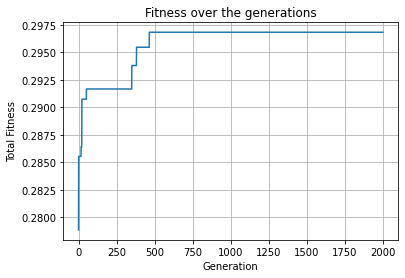

In [16]:
gen = Genetic()
timetable_, fitness = gen.loop(generations=2000)
distance = (1 /(fitness / 100))**2

**YAYY!!!!** As we can see, The fitness of the most fit gene increases over the generations.
Having terminated the evolution process, It is time to rip the benefits of our hard labour. The code cell below shows the timetable of the best fit solution after 2000 generations.

In [17]:
timetable = []
for i in timetable_:
    timetable.append(gen.info[i])
first_hour = timetable[:10]
sec_hour = timetable[10:20]
third_hour = timetable[20:30]
fourth_hour = timetable[30:40]
fifth_hour = timetable[40:]
df = pd.DataFrame(data={"Buchanan 1": [first_hour[0], sec_hour[0], third_hour[0], fourth_hour[0], fifth_hour[0]],
                           "Buchanan 2": [first_hour[1], sec_hour[1], third_hour[1], fourth_hour[1], fifth_hour[1]],
                           "Henry Angus 1": [first_hour[2], sec_hour[2], third_hour[2], fourth_hour[2], fifth_hour[2]],
                           "Henry Angus 2": [first_hour[3], sec_hour[3], third_hour[3], fourth_hour[3], fifth_hour[3]],
                           "Henry Angus 3": [first_hour[4], sec_hour[4], third_hour[4], fourth_hour[4], fifth_hour[4]],
                           "ESB 1": [first_hour[5], sec_hour[5], third_hour[5], fourth_hour[5], fifth_hour[5]],
                           "ESB 2": [first_hour[6], sec_hour[6], third_hour[6], fourth_hour[6], fifth_hour[6]],
                           "ESB 3": [first_hour[7], sec_hour[7], third_hour[7], fourth_hour[7], fifth_hour[7]],
                           "CHEM 1": [first_hour[8], sec_hour[8], third_hour[8], fourth_hour[8], fifth_hour[8]],
                           "CHEM 2": [first_hour[9], sec_hour[9], third_hour[9], fourth_hour[9], fifth_hour[9]],
                           "Hours": ["First hour", "Second hour", "third hour", "fourth hour", "Fifth Hour"]}).set_index("Hours")
df = df.style.set_caption(f"Total Distance: {int(distance)}m")
display(df)

,Buchanan 1,Buchanan 2,Henry Angus 1,Henry Angus 2,Henry Angus 3,ESB 1,ESB 2,ESB 3,CHEM 1,CHEM 2
Hours,,,,,,,,,,
First hour,['EOSC 114'],['CHEM 154'],['BIOL 140'],['CHEM 154'],['FREN 101'],['CPSC 110'],['PHYS 159'],['MATH 152'],['PHIL 120'],['PSYC 102']
Second hour,['LING 100'],['POLI 110'],['CHEM 123'],['VISA 110'],['EOSC 116'],['ATSC 113'],['ENGL 110'],['ENGL 110'],['GRSJ 101'],['SOCI 101']
third hour,['MATH 101'],['DSCI 100'],['FREN 101'],['POLI 101'],['MATH 102'],['WRDS 150'],['POLI 100'],['CHEM 123'],['PSYC 101'],['SOCI 102']
fourth hour,['PHYS 157'],['CPSC 103'],['BIOL 140'],['MATH 105'],['JAPN 100'],['CPSC 110'],['PHYS 158'],['GEOS 102'],['MATH 104'],['ANTH 100']
Fifth Hour,['CPSC 103'],['DSCI 100'],['MATH 103'],['EOSC 116'],['PHYS 131'],['ATSC 113'],['EOSC 114'],['PHYS 170'],['LING 101'],['ANTH 100']


**THANK YOU FOR CHECKING OUT THE NOTEBOOK**